# Poço Duplo Assimétrico

$V(x) = -k_2 x^2 + k_3 x^3 + k_4 x^4$

In [3]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import simps
import scipy.constants as cte
from scipy.sparse import diags
from scipy.linalg import inv
from scipy.fftpack import fft, ifft, fftfreq
import scipy.special as sp
from scipy.signal import gaussian
from scipy.stats import norm, skewnorm
from scipy.spatial.distance import cdist
from sklearn.preprocessing import StandardScaler

# matplotlib default config
import locale
locale.setlocale(locale.LC_NUMERIC, "pt_BR.UTF-8")
plt.rcParams['axes.formatter.use_locale'] = True
plt.rcParams['savefig.dpi'] = 100
plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.autolayout'] = False
plt.rcParams['figure.figsize'] = 12, 6
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 22
plt.rcParams['font.size'] = 20
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['lines.markersize'] = 8
plt.rcParams['scatter.marker'] = '.'
plt.rcParams['legend.fontsize'] = 20
plt.rcParams['font.family'] = "serif"
plt.rcParams['font.serif'] = "computer modern sans serif"
plt.rcParams['text.usetex']=True
plt.rcParams['text.latex.unicode']=True

In [77]:
# grandezas de interesse em unidades atomicas
au_l = cte.value('atomic unit of length')
au_t = cte.value('atomic unit of time')
au_e = cte.value('atomic unit of energy')

# outras relacoes de interesse
ev = cte.value('electron volt')
c = cte.value('speed of light in vacuum')
hbar_si = cte.value('Planck constant over 2 pi')
me = cte.value('electron mass')
au2ang = au_l / 1e-10
au2ev = au_e / ev

valores_x0 = {}
for x0 in [3.25, 3.5, 3.75, 4.0]:
    # otimizando
    L = (x0 * au2ang) * 2 # angstron
    N = 2048
    hN = int(N/2)
    dt = 1e-20 # s

    # unidades atomicas
    L_au = L / au2ang
    dt_au = -1j * dt / au_t

    # malhas direta e reciproca
    x_au = np.linspace(-L_au/2.0, L_au/2.0, N)
    dx_au = np.abs(x_au[1] - x_au[0])
    k_au = fftfreq(N, d=dx_au)

    # props do material
    me_eff = 0.5
    adw_k0 = 0.0#-132.7074997
    k2 = 7.0
    k3 = 0.5
    k4 = 1.0
    v_adw = lambda x: adw_k0-k2*x**2+k3*x**3+k4*x**4
    v_au = np.vectorize(v_adw)(x_au)

    # split step
    exp_v2 = np.exp(- 0.5j * v_au * dt_au)
    exp_t = np.exp(- 0.5j * (2 * np.pi * k_au) ** 2 * dt_au / me_eff)
    propagador = lambda p: exp_v2 * ifft(exp_t * fft(exp_v2 * p))
    propagador_titulo = "Split-Step"

    # chutes iniciais
    n = 9
    a = 1.9
    sigma = 0.87
    g = np.vectorize(lambda x: np.exp(-(x-a)**2/(2*sigma))+np.exp(-(x+a)**2/(2*sigma)))(x_au)
    g /= np.sqrt(simps(np.abs(g)**2, x_au))
    estados = np.array([g for _ in range(n)],dtype=np.complex_)
    valores = np.zeros(n)
    contadores = np.zeros(n)

    valores_analiticos_ev = [-12.258438, -6.045418, -5.286089, -0.646627, 0.691204, 4.053229, 7.368937, 11.235521, 15.431918]
    valores_analiticos_ev = np.array(valores_analiticos_ev) + adw_k0

    texto_x_l = -10/2
    texto_x_r = 0.7 * 10/2

    for s in range(n):
        v_ant = 1.0
        while True:
            contadores[s] += 1
            estados[s] = propagador(estados[s])

            # gram-shimdt
            for m in range(s):
                proj = simps(estados[s] * np.conjugate(estados[m]), x_au)
                estados[s] -= proj * estados[m]

            # normaliza
            estados[s] /= np.sqrt(simps(np.abs(estados[s])**2, x_au))

            if contadores[s] % 1000 == 0:
                # calcula autoestados
                # derivada segunda
                derivada2 = (estados[s][:-2] - 2 * estados[s][1:-1] + estados[s][2:]) / dx_au**2
                psi = estados[s][1:-1]
                psi_conj = np.conjugate(psi)
                # <Psi|H|Psi>
                p_h_p = simps(psi_conj * (-0.5 * derivada2 / me_eff + v_au[1:-1] * psi), x_au[1:-1])
                # divide por <Psi|Psi> 
                #p_h_p /= A
                # print(p_h_p)
                valores[s] = p_h_p.real

                #print("%d >>> %.4e / %.4e" % (contadores[s], valores[s], valores_analiticos_ev[s]))
                #if np.abs(valores[s] - valores_analiticos_ev[s]) < 0.000001:
                if np.abs(1-valores[s]/v_ant) < 0.0000001:
                    print("%d: >>> %.8e (%d)" % (s, valores[s], contadores[s]))
                    break
                else:
                    v_ant = valores[s]
    valores_x0[x0] = valores

0: >>> -1.22576393e+01 (4000)
1: >>> -6.04558810e+00 (16000)
2: >>> -5.28049026e+00 (6000)
3: >>> -6.39055988e-01 (19000)
4: >>> 6.91891599e-01 (7000)
5: >>> 4.09186003e+00 (8000)
6: >>> 7.35108349e+00 (6000)
7: >>> 1.13940255e+01 (7000)
8: >>> 1.53315749e+01 (5000)
0: >>> -1.22587710e+01 (4000)
1: >>> -6.04569152e+00 (16000)
2: >>> -5.28662706e+00 (6000)
3: >>> -6.46646932e-01 (19000)
4: >>> 6.90638696e-01 (7000)
5: >>> 4.05412196e+00 (8000)
6: >>> 7.36784885e+00 (6000)
7: >>> 1.12435832e+01 (6000)
8: >>> 1.54283341e+01 (5000)
0: >>> -1.22588101e+01 (4000)
1: >>> -6.04569605e+00 (16000)
2: >>> -5.28690050e+00 (6000)
3: >>> -6.46948655e-01 (19000)
4: >>> 6.90319044e-01 (7000)
5: >>> 4.05227255e+00 (8000)
6: >>> 7.36750196e+00 (6000)
7: >>> 1.12338080e+01 (6000)
8: >>> 1.54295138e+01 (5000)
0: >>> -1.22588122e+01 (4000)
1: >>> -6.04569733e+00 (16000)
2: >>> -5.28691138e+00 (6000)
3: >>> -6.46957597e-01 (19000)
4: >>> 6.90298747e-01 (7000)
5: >>> 4.05222285e+00 (8000)
6: >>> 7.36744449e+

0: >>> -1.22587710e+01 (4000)
1: >>> -6.04569152e+00 (16000)
2: >>> -5.28662706e+00 (6000)
3: >>> -6.46646932e-01 (19000)
4: >>> 6.90638696e-01 (7000)
5: >>> 4.05412196e+00 (8000)
6: >>> 7.36784885e+00 (6000)
7: >>> 1.12435832e+01 (6000)
8: >>> 1.54283341e+01 (5000)


/home/thiago/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


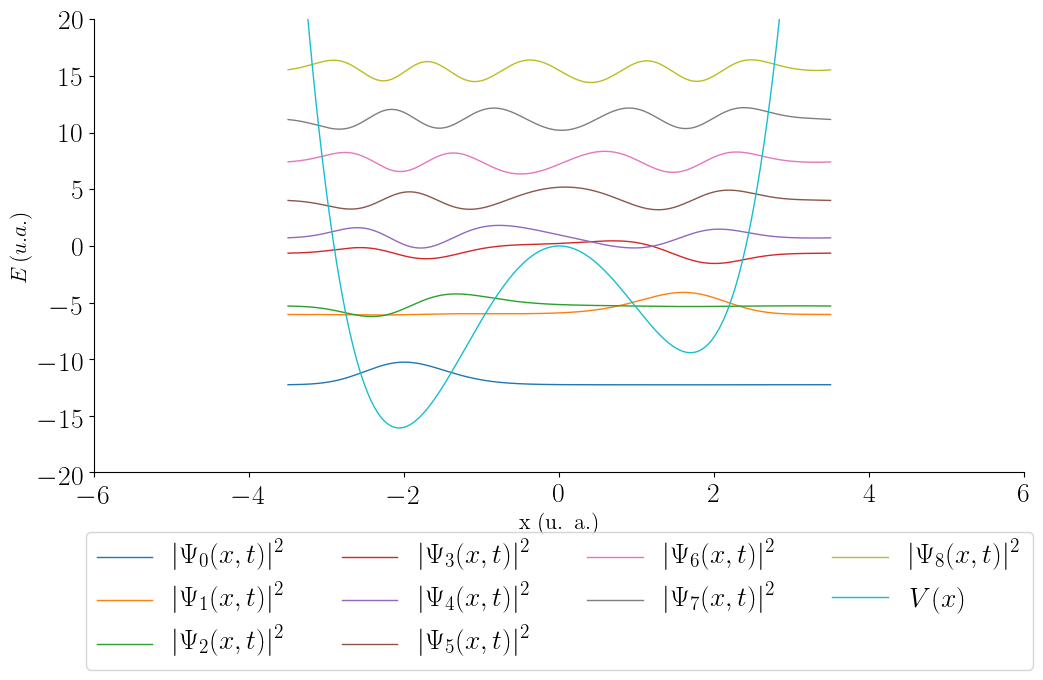

In [64]:

# especificos do grafico
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.set_ylim([-20 + adw_k0,20 + adw_k0])
ax.set_xlim([-6, 6])
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
#plt.title("Autoestados/Autovalores Poço Suplo Assimétrico (%s)" % (propagador_titulo), fontsize=18)
plt.xlabel("x (u. a.)", fontsize=16)
plt.ylabel(r'$E \, (u. a.)$', fontsize=16)

psif = [estados[m] for m in range(n)]
psif = [2 * p / np.ptp(p) + valores[m] for m, p in enumerate(psif)]
lines = []
for i, p in enumerate(psif):
    line, = plt.plot(x_au, p, lw=1.0, label=r'$|\Psi_{%d} (x,t)|^2$' % i)
    lines.append(line)

#     if i < len(psif) - 1 and valores[i+1]-valores[i] < 2.0:
#         ax.text(texto_x_l, valores[i] - 1, r"$E_{%d} = %.5f$ eV" % (i, valores[i]))
#         ax.text(texto_x_r, valores[i] - 1, r"$%d k$ iterações" % int(contadores[i]/1000))
#     else:
#         ax.text(texto_x_l, valores[i] + 0.3, r"$E_{%d} = %.5f$ eV" % (i, valores[i]))
#         ax.text(texto_x_r, valores[i] + 0.3, r"$%d k$ iterações" % int(contadores[i]/1000))

linev, = plt.plot(x_au, v_au, lw=1.0, label='$V(x)$')
lines.append(linev)
plt.legend(handles=lines, loc=9, bbox_to_anchor=(0.5, -0.1), ncol=4)
plt.show()

/home/thiago/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


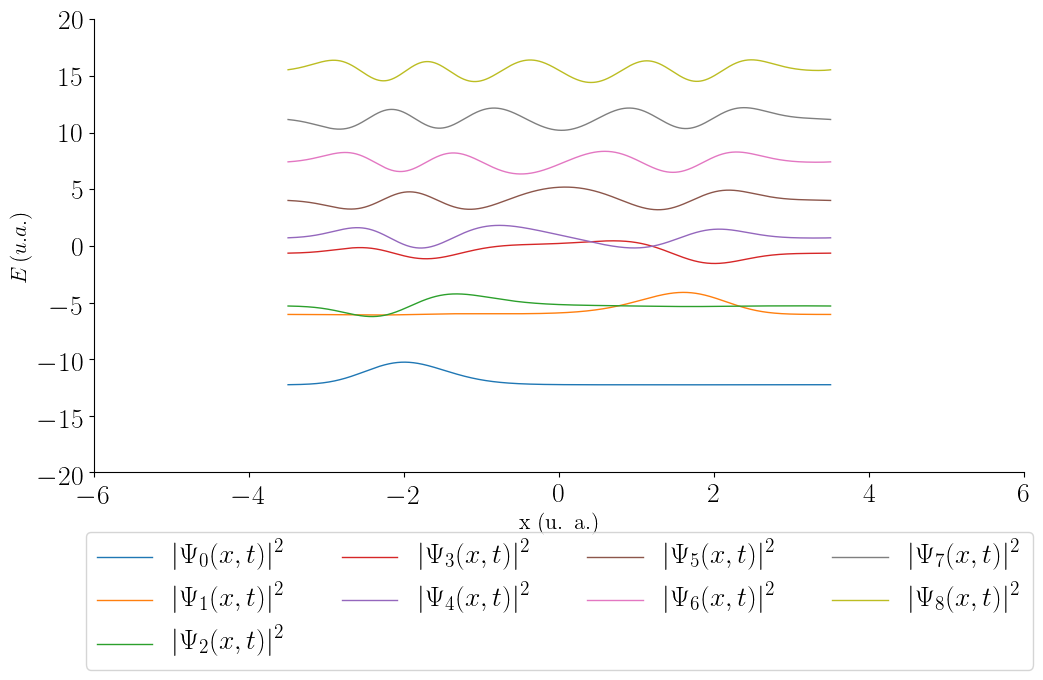

In [65]:
# especificos do grafico
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.set_ylim([-20 + adw_k0,20 + adw_k0])
ax.set_xlim([-6, 6])
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
#plt.title("Autoestados/Autovalores Poço Suplo Assimétrico (%s)" % (propagador_titulo), fontsize=18)
plt.xlabel("x (u. a.)", fontsize=16)
plt.ylabel(r'$E \, (u. a.)$', fontsize=16)

psif = [estados[m] for m in range(n)]
psif = [2 * p / np.ptp(p) + valores[m] for m, p in enumerate(psif)]
lines = []
for i, p in enumerate(psif):
    line, = plt.plot(x_au, p, lw=1.0, label=r'$|\Psi_{%d} (x,t)|^2$' % i)
    lines.append(line)

#     if i < len(psif) - 1 and valores[i+1]-valores[i] < 2.0:
#         ax.text(texto_x_l, valores[i] - 1, r"$E_{%d} = %.5f$ eV" % (i, valores[i]))
#         ax.text(texto_x_r, valores[i] - 1, r"$%d k$ iterações" % int(contadores[i]/1000))
#     else:
#         ax.text(texto_x_l, valores[i] + 0.3, r"$E_{%d} = %.5f$ eV" % (i, valores[i]))
#         ax.text(texto_x_r, valores[i] + 0.3, r"$%d k$ iterações" % int(contadores[i]/1000))

#linev, = plt.plot(x_au, v_au, lw=1.0, label='$V(x)$')
#lines.append(linev)
plt.legend(handles=lines, loc=9, bbox_to_anchor=(0.5, -0.1), ncol=4)
plt.show()

In [42]:
device = {
    'x_au': x_au,
    'v_au': v_au
}

for i, state in enumerate(estados):
    device['state_%02d' % i] = state
    device['state_%02d_squared' % i] = np.abs(state)**2

device = pd.DataFrame(device)
#device.to_csv('results/asymmetric_double_well.csv')

/home/thiago/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


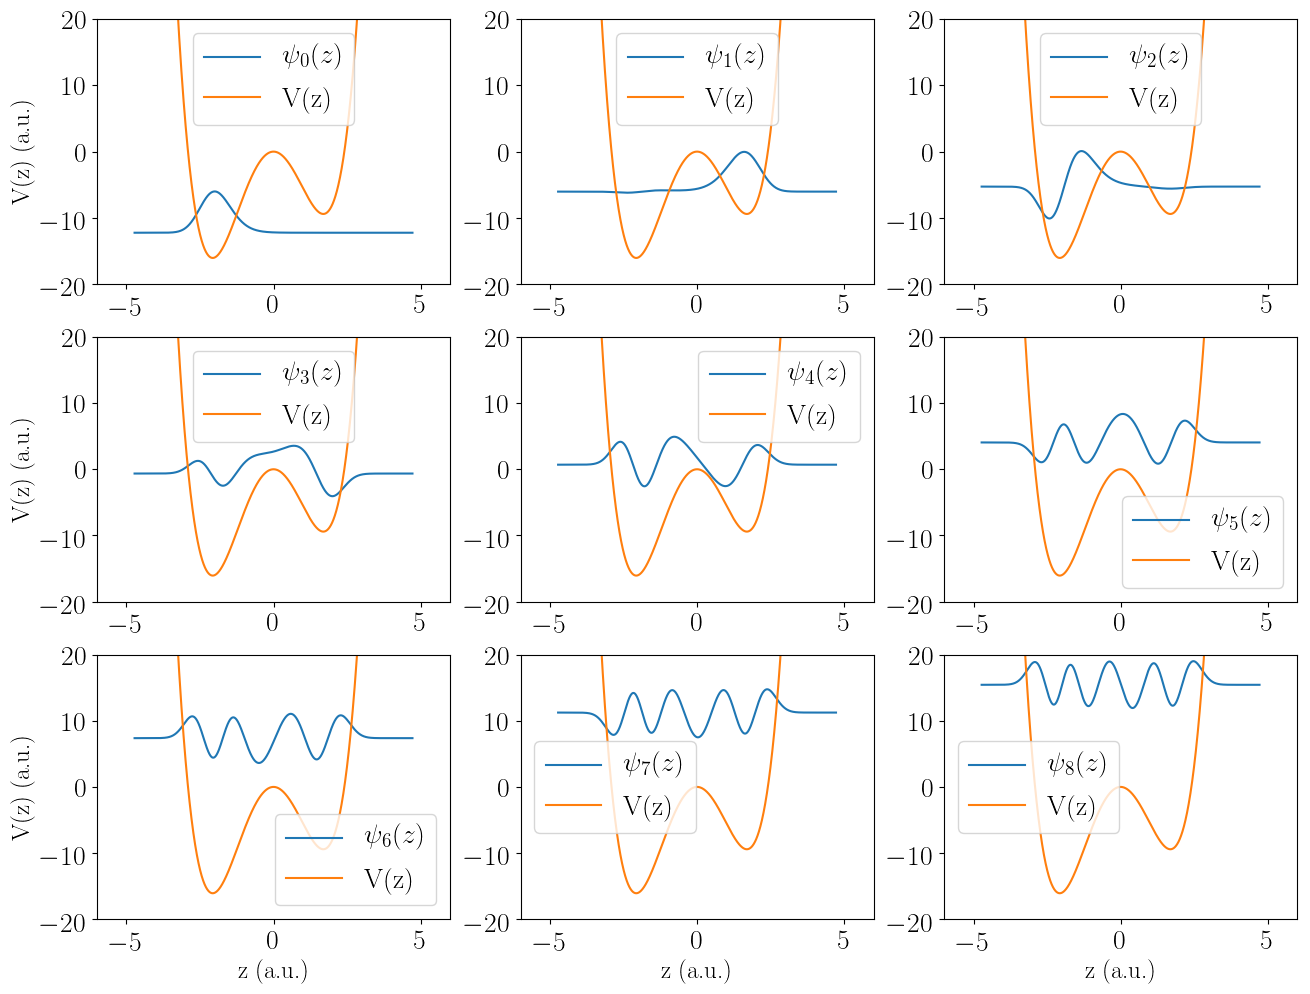

In [43]:
fig, axs = plt.subplots(3,3)
for i in range(3):
    for j in range(3):
        if (3*i+j) >= len(estados):
            continue
        axs[i,j].set_xlim([-6, 6])
        axs[i,j].set_ylim([-20 + adw_k0,20 + adw_k0])
        axs[i,j].plot(x_au, 6*np.array(estados[3*i+j]) + valores[3*i+j], label=r'$\psi_%d (z)$' % (3*i+j))
        axs[i,j].plot(x_au, v_au, label='V(z)')
        axs[i,j].legend()
        
        if i == 2:
            axs[i,j].set_xlabel(r'z (a.u.)')
        if j == 0:
            axs[i,j].set_ylabel(r'V(z) (a.u.)')
        #axs[i,j].set_ylabel(r'$|\psi_{%d} (z)|^2$' % (3*i+j))
plt.subplots_adjust(left=0.0, right=1.0, top=1.5, bottom=0.0, wspace=None, hspace=None)
plt.show()
#plt.savefig('poco_duplo_assimetrico.png', bbox_inches='tight')

In [73]:
feit       = [-12.258438, -6.045418, -5.286089, -0.646627, 0.691204, 4.053229, 7.368937, 11.235521, 15.431918]
russos_325 = [-12.258992, -6.045790, -5.289386, -0.652531, 0.666824, 4.009543, 7.241761, 10.819522, 14.581101]
russos_350 = [-12.258824, -6.045688, -5.287076, -0.647054, 0.689775, 4.051291, 7.364894, 11.227179, 15.413241]
russos_375 = [-12.258805, -6.045688, -5.286878, -0.646579, 0.690373, 4.052328, 7.367605, 11.233792, 15.429527]
russos_400 = [-12.258799, -6.045687, -5.286859, -0.646541, 0.690390, 4.052355, 7.367668, 11.233904, 15.429861]

def dist(x,y,p=2.0):
    return (np.sum(np.abs(np.array(x)-np.array(y))**p))**(1.0/p)

In [78]:
print(dist(valores_x0[3.25],russos_325))
print(dist(feit,russos_325))
print('-----------------------')
print(dist(valores_x0[3.5],russos_350))
print(dist(feit,russos_350))
print('-----------------------')
print(dist(valores_x0[3.75],russos_375))
print(dist(feit,russos_375))
print('-----------------------')
print(dist(valores_x0[4.0],russos_400))
print(dist(feit,russos_400))
print('-----------------------')

0.9554495717538758
0.956905164677775
-----------------------
0.022688344422380404
0.021022402836022955
-----------------------
0.0003927772728588014
0.00357984943817476
-----------------------
0.0008120489271670742
0.0032689063920511544
-----------------------


In [50]:
comparacao = pd.DataFrame({'feit':feit, 'russos_35':russos_35,'pe':valores})
comparacao

,feit,pe,russos
0,-12.258438,-12.258802,-12.258824
1,-6.045418,-6.045689,-6.045688
2,-5.286089,-5.286868,-5.287076
3,-0.646627,-0.646927,0.647054
4,0.691204,0.690376,0.689775
5,4.053229,4.052345,4.051291
6,7.368937,7.367645,7.364894
7,11.235521,11.233958,11.227179
8,15.431918,15.429833,15.413241


In [1]:
valores_x0

NameError: name 'valores_x0' is not defined

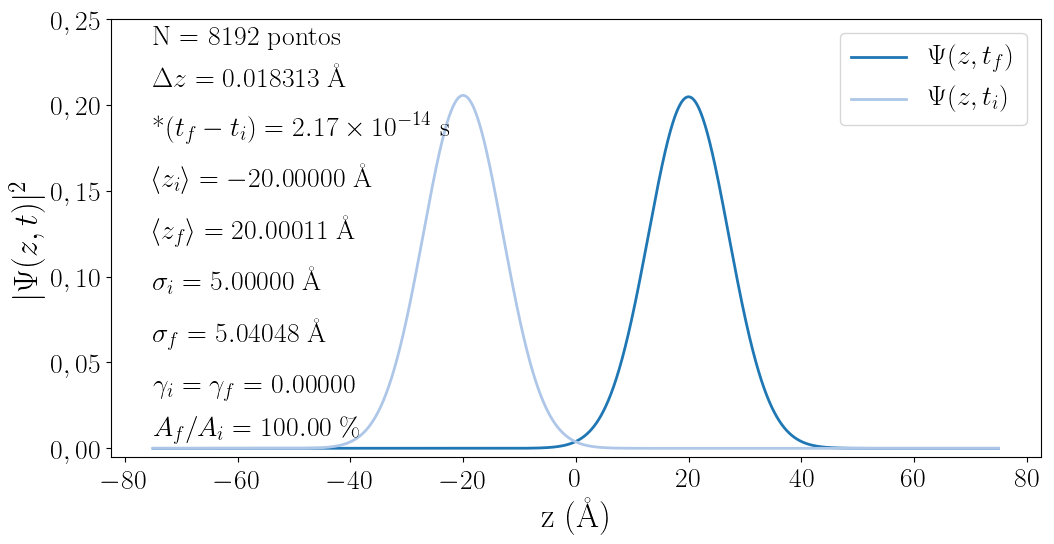

In [12]:
# grandezas de interesse em unidades atomicas
au_l = cte.value('atomic unit of length')
au_t = cte.value('atomic unit of time')
au_e = cte.value('atomic unit of energy')

# outras relacoes de interesse
ev = cte.value('electron volt')
au2ang = au_l / 1e-10
au2ev = au_e / ev

# constantes do problema
E0 = 150.0 # eV
delta_x = 5.0 # angstron
x0 = -20.0 # angstron

# otimizando
L = 150 # angstron
N = 8192 # pontos
tt = 2.17395e-14 # tempo total de evolução em segundos

# transforma para unidades atomicas
L_au = L / au2ang
E0_au = E0 / au2ev
delta_x_au = delta_x / au2ang
t_au = tt / au_t
x0_au = x0 / au2ang
k0_au = np.sqrt(2 * E0_au)

# malhas direta e reciproca
dx = L / (N-1)
x_au = np.linspace(-L_au/2.0, L_au/2.0, N)
dx_au = np.abs(x_au[1] - x_au[0])
k_au = fftfreq(N, d=dx_au)

# pacote de onda inicial
PN = 1/(2*np.pi*delta_x_au**2)**(1/4)
psi = PN*np.exp(1j*k0_au*x_au-(x_au-x0_au)**2/(4*delta_x_au**2))
A0 = simps(np.abs(psi)**2,x_au) # norma inicial
psi0 = np.copy(psi) # salva uma copia da onda inicial

# valores iniciais
xm = x0_au
contador = 0
texto_x = -L/2

# IMPLEMENTACAO DE FATO DA SOLUCAO PSEUDO ANALITICA
psi_k = fft(psi) # FFT do pacote inicial
omega_k = k_au**2 / 2
# transformada inversa do pacote de onda multiplicado
# por uma funcao com a dependencia temporal
psi = ifft(psi_k * np.exp(-1j * omega_k * t_au))

# indicadores principaus
A = simps(np.abs(psi)**2,x_au).real # norma
var_norma = 100 * A / A0 # conservacao da norma
psis = np.conjugate(psi) # complexo conjugado
xm = (simps(psis * x_au * psi,x_au)).real / A # posicao media final <x>

# indicadores secundarios
xm2 = simps(psis * x_au**2 * psi,x_au).real / A
xm3 = simps(psis * x_au**3 * psi,x_au).real / A
desvpad = np.sqrt(np.abs(xm2 - xm**2)) # desvio padrao
skewness = (xm3 - 3*xm*desvpad**2-xm**3)/desvpad**3 # obliquidade

# especificos do grafico
def as_si(x, ndp):
    s = '{x:0.{ndp:d}e}'.format(x=x, ndp=ndp)
    m, e = s.split('e')
    return r'{m:s}\times 10^{{{e:d}}}'.format(m=m, e=int(e))
    
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.set_ylim([-0.005,0.25])
# ax.text(-14, 0.22, r"$\mathbf{L = %.2f}$ \textbf{\AA}" % (L), \
#         color='red', fontsize=24)
ax.text(texto_x, 0.235, r"N = %d pontos" % N)
ax.text(texto_x, 0.21, r"$\Delta z = {0:5f}$ \AA".format(dx))
ax.text(texto_x, 0.18, r"*$(t_f-t_i) = %s$ s" % \
        (as_si(t_au * au_t, 2)))
ax.text(texto_x, 0.15, r"$\langle z_i \rangle = %.5f$ \AA" % \
        (x0_au * au2ang))
ax.text(texto_x, 0.12, r"$\langle z_f \rangle = %.5f$ \AA" % \
        (xm * au2ang))
ax.text(texto_x, 0.09, r"$\sigma_i = %.5f$ \AA" % (delta_x_au * au2ang))
ax.text(texto_x, 0.06, r"$\sigma_f = %.5f$ \AA" % (desvpad * au2ang))
ax.text(texto_x, 0.03, r"$\gamma_i = \gamma_f = %.5f$" % \
        np.abs(skewness))
ax.text(texto_x, 0.005, r"$A_f/A_i = %.2f$ \%%" % (var_norma))
plt.gcf().subplots_adjust(bottom=0.15)
plt.xlabel("z (\AA)", fontsize=24)
plt.ylabel(r'$|\Psi (z,t)|^2$', fontsize=24)
line1, = plt.plot(x_au * au2ang, np.abs(psi), lw=2.0, \
    color=(31/255, 119/255, 180/255), label='$\Psi(z,t_f)$')
line2, = plt.plot(x_au * au2ang, np.abs(psi0), lw=2.0, \
    color=(174/255, 199/255, 232/255), label='$\Psi(z,t_i)$')
plt.legend(handles=[line1,line2], loc=1)
#plt.show()
plt.savefig('pacote_onda_plana_solucao_analitica.png', bbox_inches='tight')

In [11]:
from quantum_well import QuantumWell

In [12]:
device = QuantumWell(well_length=50.0, well_height=1.0, N=2048, dt=1e-18)
device.evolve_imaginary(precision=1e-4)

In [13]:
device.eigenvalues

array([ 0.01295187,  0.05175222,  0.11623531,  0.20610841,  0.32087362,
        0.4596782 ,  0.62092867,  0.80102194,  0.98405183])

In [14]:
device.analytical_eigenvalues = np.array(device.analytical_solution())
device.analytical_eigenvalues

array([ 0.0129374 ,  0.05169975,  0.11612905,  0.20592968,  0.32060263,
        0.45929849,  0.62043969,  0.80041283,  0.98285879])

In [15]:
eigenvalues = pd.DataFrame({'analytic': device.analytical_eigenvalues, 'numeric': device.eigenvalues})
eigenvalues['error (%)'] = eigenvalues.apply(lambda l: 100.0*(l['numeric']/l['analytic']-1.0), axis=1)
eigenvalues

,analytic,numeric,error (%)
0,0.012937,0.012952,0.111857
1,0.051700,0.051752,0.101488
2,0.116129,0.116235,0.091498
3,0.205930,0.206108,0.086792
4,0.320603,0.320874,0.084524
5,0.459298,0.459678,0.082673
6,0.620440,0.620929,0.078811
7,0.800413,0.801022,0.076099
8,0.982859,0.984052,0.121385


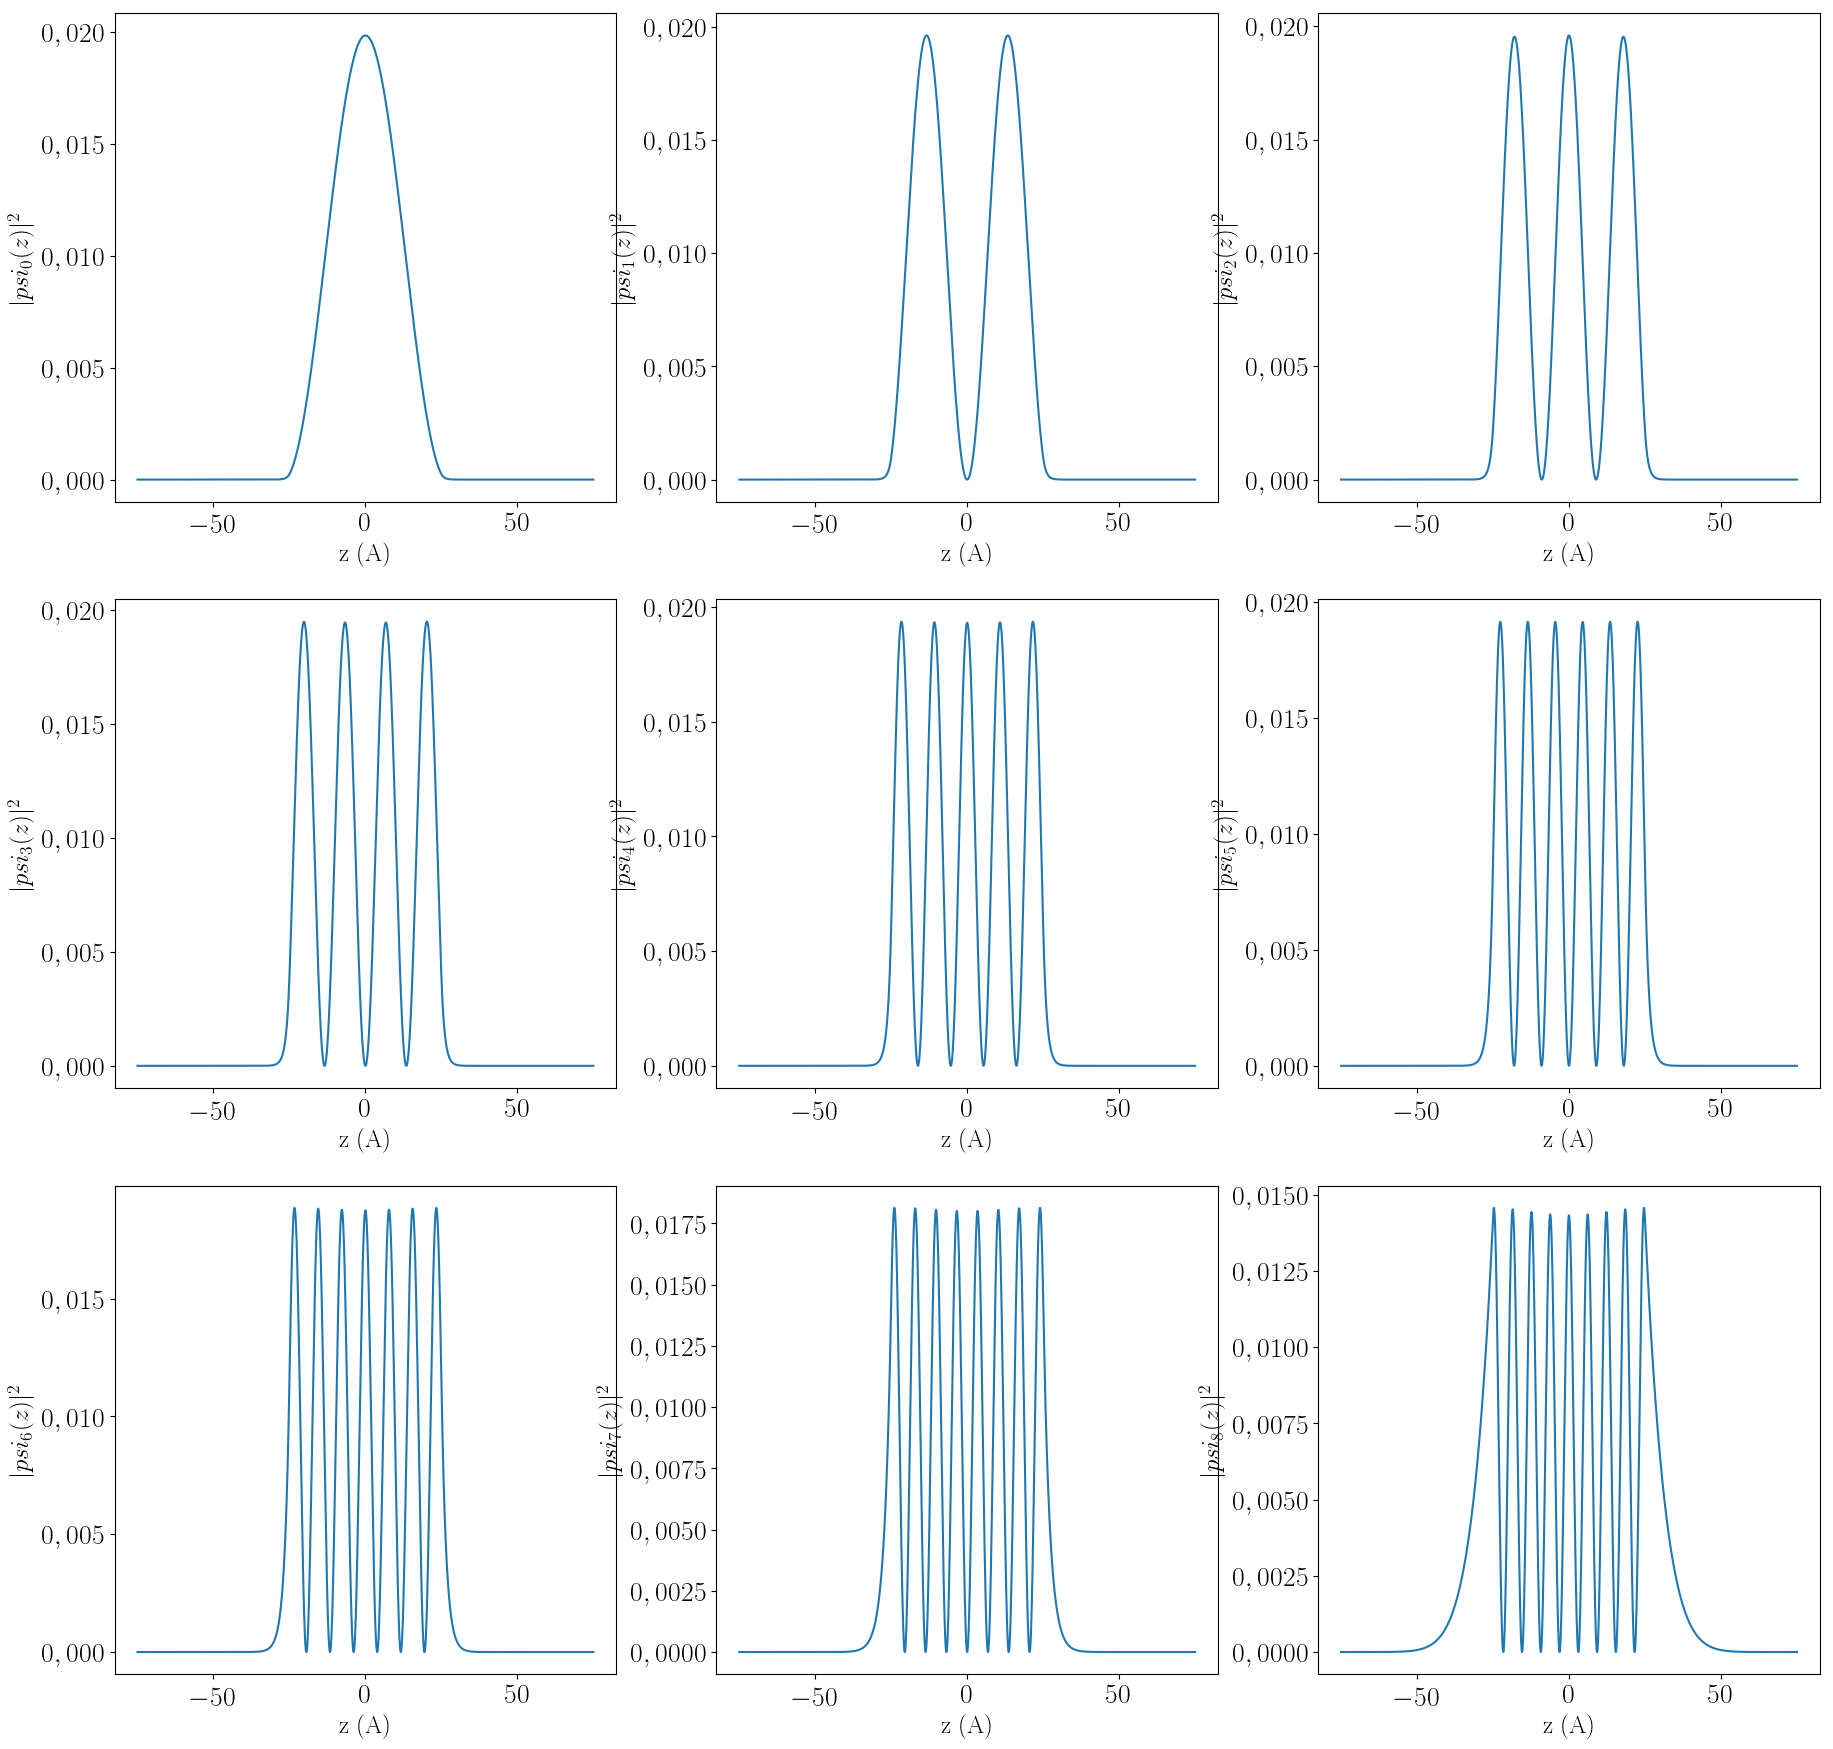

In [17]:
fix, axs = plt.subplots(3,3, figsize=(22,22))
for i in range(3):
    for j in range(3):
        if (3*i+j) >= len(device.eigenstates):
            continue
        axs[i,j].plot(device.z_ang, np.abs(device.eigenstates[3*i+j])**2)
        axs[i,j].set_xlabel(r'z (A)')
        axs[i,j].set_ylabel(r'$|psi_{%d} (z)|^2$' % (3*i+j))
plt.show()

In [18]:
z = device.z_ang
def normalize2ang(psi):
    # psi / (<psi|psi>)^(1/2)
    return psi / np.sqrt(simps(psi.conj()*psi,z))
device.eigenstates_ang = [normalize2ang(es) for es in device.eigenstates]

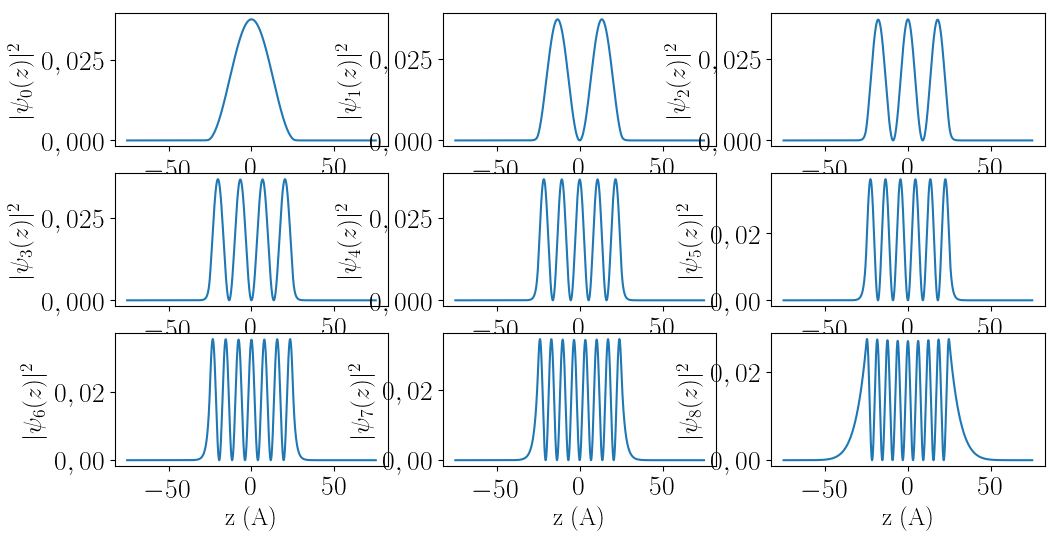

In [20]:
fix, axs = plt.subplots(3,3)
for i in range(3):
    for j in range(3):
        if (3*i+j) >= len(device.eigenstates_ang):
            continue
        axs[i,j].plot(device.z_ang, np.abs(device.eigenstates_ang[3*i+j])**2)
        axs[i,j].set_xlabel(r'z (A)')
        axs[i,j].set_ylabel(r'$|\psi_{%d} (z)|^2$' % (3*i+j))
plt.show()

In [21]:
export_values = {
    'z_ang': device.z_ang, # o eixo z em Angstrom
    'v_ev': device.v_ev, # o potencial em eV
}

for i, state in enumerate(device.eigenstates_ang):
    export_values['psi_%02d' % i] = state # psi
    export_values['psi_squared_%d' % i] = np.abs(state)**2 # |psi|^2
results = pd.DataFrame(export_values)
results.to_csv('results/quantum_well_states_50.csv')
results.head()

,psi_00,psi_01,psi_02,psi_03,psi_04,psi_05,psi_06,psi_07,psi_08,psi_squared_0,psi_squared_1,psi_squared_2,psi_squared_3,psi_squared_4,psi_squared_5,psi_squared_6,psi_squared_7,psi_squared_8,v_ev,z_ang
0,(3.5429162229e-13-9.20316961923e-15j),(-2.16380582499e-14-7.35042501966e-16j),(3.63468510008e-12+7.50820876681e-15j),(-2.72041143321e-13-1.29034998686e-15j),(7.395067975e-11-5.54017918874e-15j),(-7.62482203253e-12+2.15705190169e-15j),(6.09246392207e-09+8.34052185906e-15j),(-1.49760892741e-09-2.46808027369e-15j),(0.000189232550886+6.06473430038e-14j),1.256073e-25,4.687459e-28,1.321099e-23,7.400805e-26,5.468703e-21,5.813792e-23,3.711812e-17,2.242832e-18,3.580896e-08,1.0,-75.000000
1,(3.54768205048e-13-9.12567564991e-15j),(-4.15554023801e-14-8.28071256066e-16j),(3.63947074146e-12+7.47252543311e-15j),(-7.21527692148e-13-1.18428032215e-15j),(7.40335295113e-11-5.42108777521e-15j),(-2.27651593937e-11+1.99200222051e-15j),(6.09769841192e-09+8.3213030919e-15j),(-4.49370733288e-09-2.46907585307e-15j),(0.000189284191618+6.05148223206e-14j),1.259438e-25,1.727537e-27,1.324580e-23,5.206036e-25,5.480964e-21,5.182525e-22,3.718193e-17,2.019341e-17,3.582851e-08,1.0,-74.926722
2,(3.55797623805e-13-9.04414305858e-15j),(-1.04025680511e-13-9.16126952385e-16j),(3.64904202415e-12+7.43437139183e-15j),(-1.25705128685e-12-1.119033416e-15j),(7.41996295507e-11-5.29367912791e-15j),(-3.80548707655e-11+1.77900454761e-15j),(6.10817197105e-09+8.29518603706e-15j),(-7.49307736344e-09-2.46314841463e-15j),(0.000189387483433+6.03701867079e-14j),1.266737e-25,1.082218e-26,1.331556e-23,1.580179e-24,5.505585e-21,1.448173e-21,3.730976e-17,5.614621e-17,3.586762e-08,1.0,-74.853444
3,(3.57208308769e-13-8.98501349033e-15j),(-1.2414997801e-13-1.01744946984e-15j),(3.66313202007e-12+7.41076090405e-15j),(-1.70894558263e-12-1.03966329971e-15j),(7.44484458463e-11-5.17475092469e-15j),(-5.32565859669e-11+1.56368341721e-15j),(6.12389228906e-09+8.28475241609e-15j),(-1.04974689443e-08-2.48038181845e-15j),(0.000189542447027+6.02378550963e-14j),1.276785e-25,1.541425e-26,1.341859e-23,2.920496e-24,5.542571e-21,2.836264e-21,3.750206e-17,1.101969e-16,3.592634e-08,1.0,-74.780166
4,(3.59267146283e-13-8.9231268111e-15j),(-1.86941074822e-13-1.11377439637e-15j),(3.68236991696e-12+7.38361760582e-15j),(-2.24808422418e-12-9.42701849865e-16j),(7.4781313453e-11-5.04410366174e-15j),(-6.863844875e-11+1.39554673832e-15j),(6.1448738293e-09+8.26555889462e-15j),(-1.35092854235e-08-2.48725526003e-15j),(0.000189749113455+6.010182409e-14j),1.291525e-25,3.494821e-26,1.355990e-23,5.053884e-24,5.592245e-21,4.711237e-21,3.775947e-17,1.825008e-16,3.600473e-08,1.0,-74.706888


In [22]:
perf_metrics = pd.DataFrame({
    'time (s)': device.timers,
    'iterations': device.counters,
    'numeric precision (%)': 100*device.eigenvalues_precisions,
    'analytic (eV)': device.analytical_eigenvalues,
    'numeric (eV)': device.eigenvalues,
    'actual precision (%)': 100.0*(device.eigenvalues/device.analytical_eigenvalues-1.0)
})
perf_metrics.to_csv('results/quantum_well_perf_metrics_50.csv')
perf_metrics

,actual precision (%),analytic (eV),iterations,numeric (eV),numeric precision (%),time (s)
0,0.111857,0.012937,33000,0.012952,0.008783,13.947237
1,0.101488,0.051700,24000,0.051752,0.008362,18.265015
2,0.091498,0.116129,16000,0.116235,0.006467,17.561082
3,0.086792,0.205930,14000,0.206108,0.005649,20.077805
4,0.084524,0.320603,11000,0.320874,0.005106,19.525697
5,0.082673,0.459298,10000,0.459678,0.005775,21.044518
6,0.078811,0.620440,9000,0.620929,0.003641,21.912029
7,0.076099,0.800413,9000,0.801022,0.005339,25.022355
8,0.121385,0.982859,18000,0.984052,0.009144,57.480376


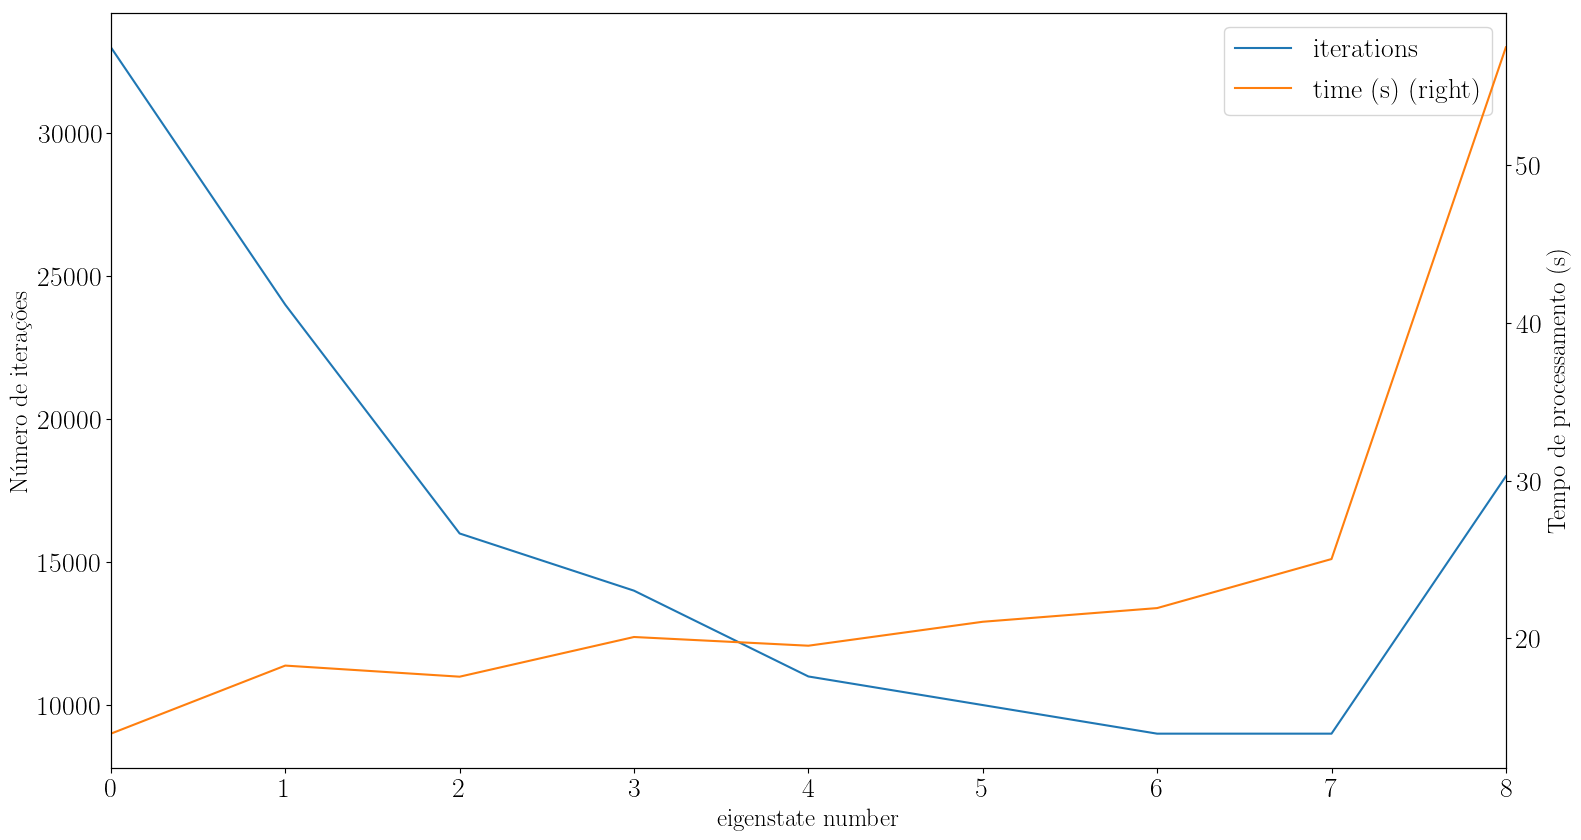

In [23]:
metrics = perf_metrics.copy()
metrics.reset_index(inplace=True)
ax = metrics[['iterations', 'time (s)']].plot(secondary_y='time (s)', figsize=(18,10))
ax.set_xlabel('eigenstate number')
ax.set_ylabel('Número de iterações')
ax.right_ax.set_ylabel('Tempo de processamento (s)')
plt.show()

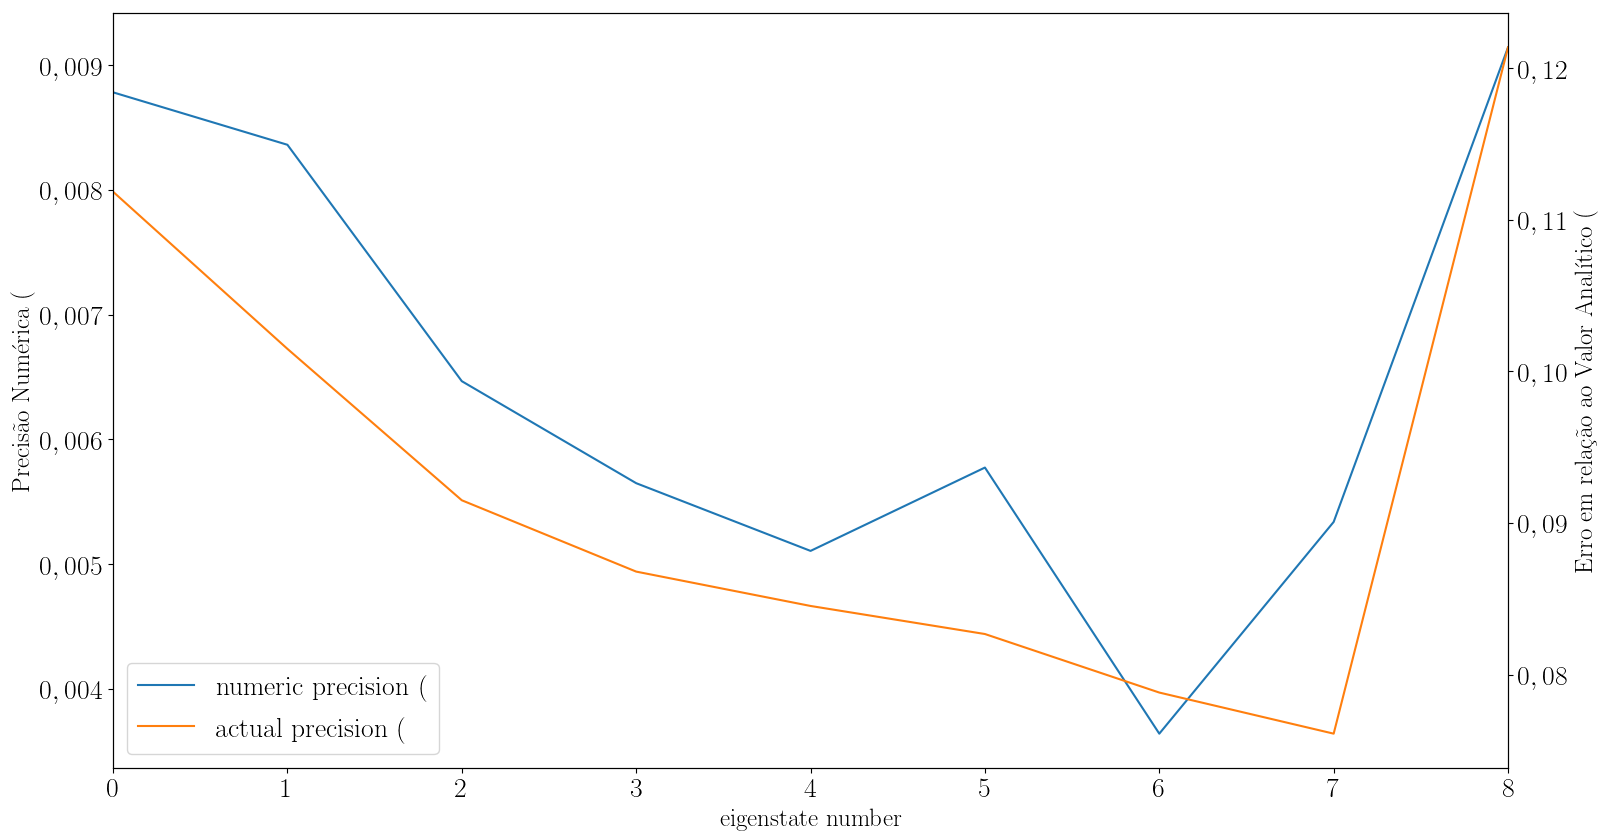

In [24]:
ax = metrics[['numeric precision (%)', 'actual precision (%)']].plot(secondary_y='actual precision (%)', figsize=(18,10))
ax.set_xlabel('eigenstate number')
ax.set_ylabel('Precisão Numérica (%)')
ax.right_ax.set_ylabel('Erro em relação ao Valor Analítico (%)')
plt.show()

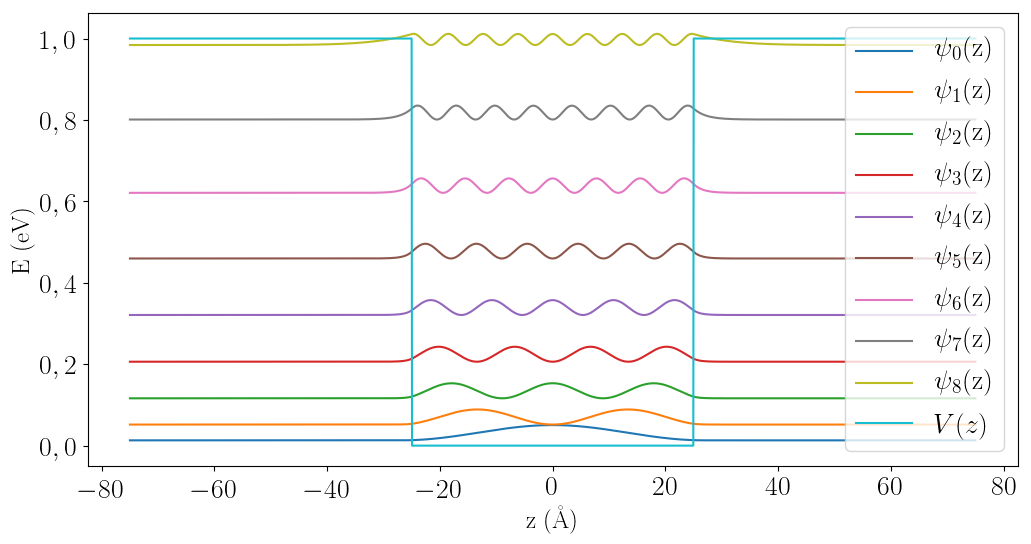

In [39]:
fig, ax = plt.subplots(1,1)
ax.set_xlabel(r'z (\AA)')
ax.set_ylabel(r'E (eV)')
for i in range(9):
    ax.plot(device.z_ang, device.eigenvalues[i]+np.abs(device.eigenstates_ang[i])**2, label=r'$\psi_%d$(z)' % i)
ax.plot(device.z_ang, device.v_ev, label=r'$V(z)$')
plt.legend()
plt.savefig('poco_quantico_numerico_autoestados.png', bbox_inches='tight')